In [1]:
import numpy as np
from nudging.simulation import generate_datasets
from sklearn.linear_model import BayesianRidge, LogisticRegression
from nudging.model import BiRegressor
from nudging.model import ProbModel, MDMModel, PCAModel
from nudging.cate import get_cate_correlations
from nudging.correlation import smooth_data_2
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from copy import deepcopy
from nudging.evaluate_outcome import evaluate_performance
from scipy.stats import sem
from utils import get_datasets, get_correlations, parameter_descriptions

### Generate datasets

In [2]:
sim_datasets = get_datasets(n=5000)

In [3]:
sub_results = get_correlations(sim_datasets)

In [4]:
results = {name: values["individual"] for name, values in sub_results.items()}

In [5]:
np.max(results["t-learner (ARD)"]), np.min(results["t-learner (ARD)"])

(0.9860131934866754, -0.5615485003762076)

### Plot correlation of both models against each other

From the plot below, it shows that the difference between the two models is a lot bigger with a higher number of features (~26%).

In [6]:
print("CATE correlation\n\n")
print("Model"+" "*29+"All"+" "*12+"Linear" + " "*8+"Non-linear")
print("-"*75)
linear = np.array([dataset.linear for dataset in sim_datasets])
for name, x in results.items():
    x = np.array(x)
    all_results = f"{np.mean(x):.3f} +- {sem(x):.3f}"
    linear_results = f"{np.mean(x[linear]):.3f} +- {sem(x[linear]):.3f}"
    non_linear_results = f"{np.mean(x[~linear]):.3f} +- {sem(x[~linear]):.3f}"
    print(f"{name:27}| {all_results}, {linear_results}, {non_linear_results}")


CATE correlation


Model                             All            Linear        Non-linear
---------------------------------------------------------------------------
t-learner (ARD)            | 0.293 +- 0.004, 0.412 +- 0.006, 0.170 +- 0.004
propensity_classifier (log)| 0.239 +- 0.004, 0.374 +- 0.005, 0.099 +- 0.003
propensity_regressor (ARD) | 0.240 +- 0.004, 0.382 +- 0.005, 0.093 +- 0.003
mdm (ARD)                  | 0.245 +- 0.004, 0.344 +- 0.006, 0.144 +- 0.004
pca (ARD)                  | 0.240 +- 0.004, 0.339 +- 0.006, 0.137 +- 0.004


In [7]:
def plot_correlations(attr, datasets, results, n_data_smooth=50):
    all_attr_desc = parameter_descriptions()
    attr_desc = all_attr_desc.get(attr, attr)
    x = np.array([data.truth[attr] for data in datasets])
    channel_name = "CATE"
    for linear in [True, False]:
        idx = np.where([data.truth["linear"] == linear for data in datasets])[0]
        plt.figure(dpi=150)

        if linear:
            plt.title("Linear")
        else:
            plt.title("Non-Linear")
        for name, res in results.items():
            res = np.array(res)
            xcor = spearmanr(x[idx], res[idx]).correlation
            x_smooth, y_smooth = smooth_data_2(x[idx], res[idx], n_data=n_data_smooth)
            plt.plot(x_smooth, y_smooth, label=f"{name}")
        plt.xlabel(attr_desc)
        plt.ylabel(f"{channel_name} correlation")

        plt.legend()
        plt.show()

### Plot correlations as a function of the dataset parameters

Below we show differences between the two algorithms with respect to the properties of the dataset.

First up is the amount of noise added to the feature matrix. Obviously, more noise means worse results. On the other hand, it seems like the t-learner is better at extracting information out of less noisy data.

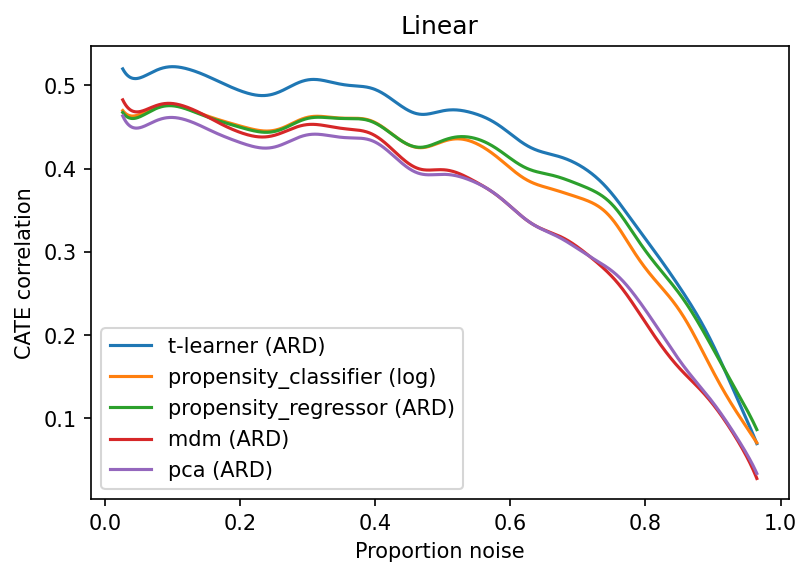

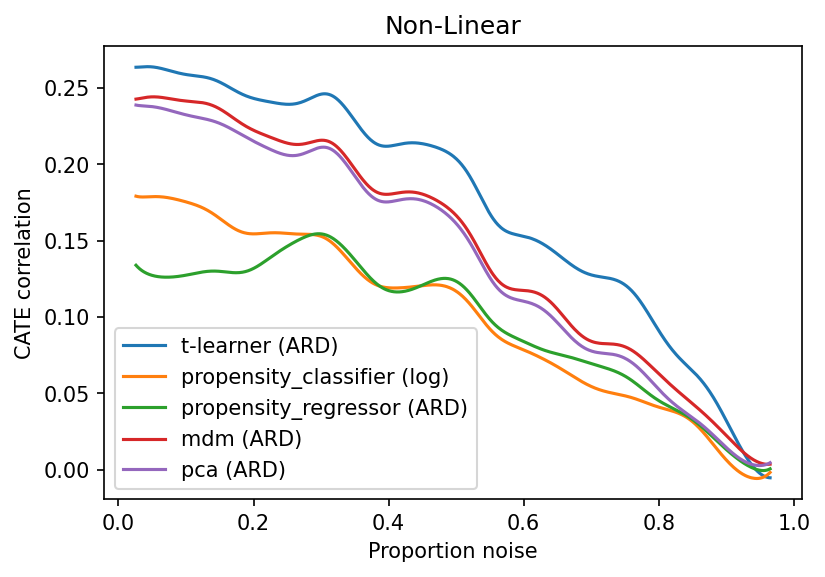

In [8]:
plot_correlations("noise_frac", sim_datasets, results, n_data_smooth=30)

From the next plot it seems that the number of samples a reasonably strong influence now.

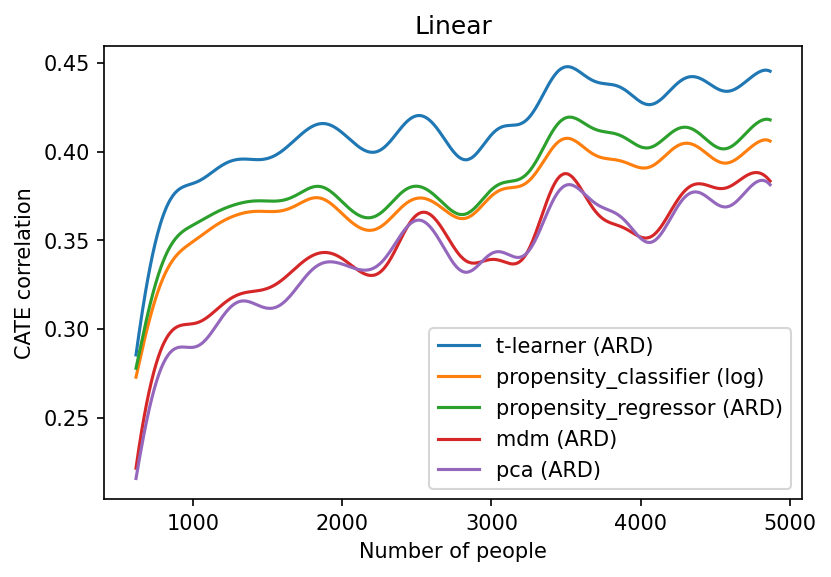

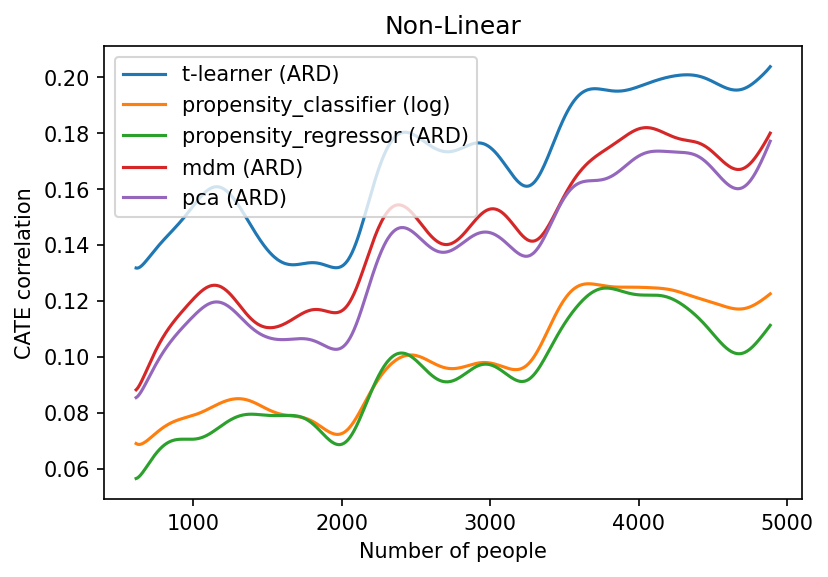

In [9]:
plot_correlations("n_samples", sim_datasets, results, n_data_smooth=30)

Next up is the `control_precision` parameter that signifies how much the outcome of the untreated/control group depends on the other features, with higher values indicating stronger relations. It looks like the probabilistic method has more trouble with stronger relations for the control group, but the difference is relatively uniform.

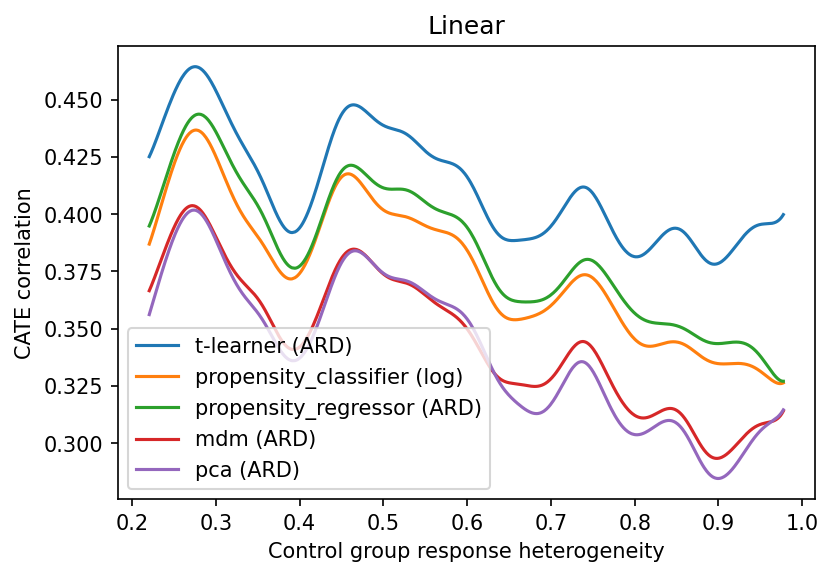

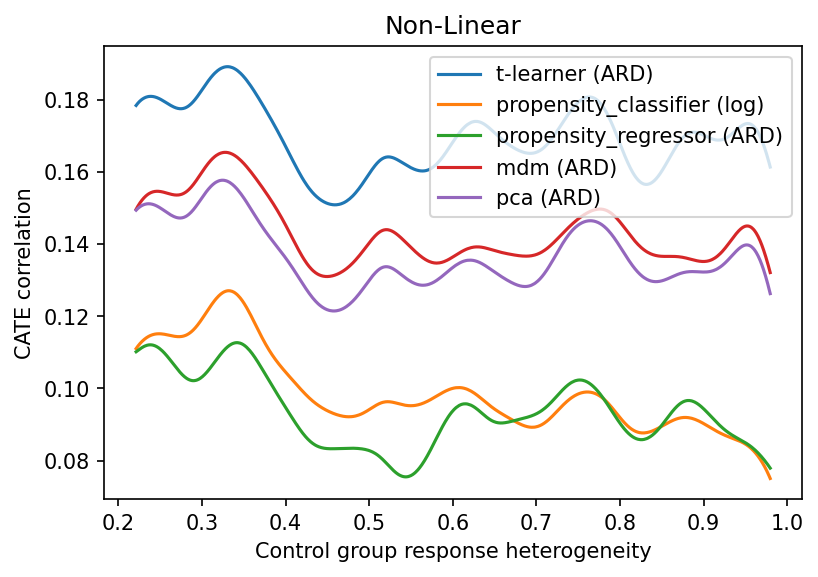

In [10]:
plot_correlations("control_precision", sim_datasets, results, n_data_smooth=30)

The last parameter to be looked at is `control_unique`. This controls how similar the responses are for the control group and the treatment group. If the parameter is 1, then it means that there is likely to be less correlation between the control and treatment responses. Differences are small, but it seems like the t-learner has a harder time with lower values, while the probabilistic method has a harder time with larger values.

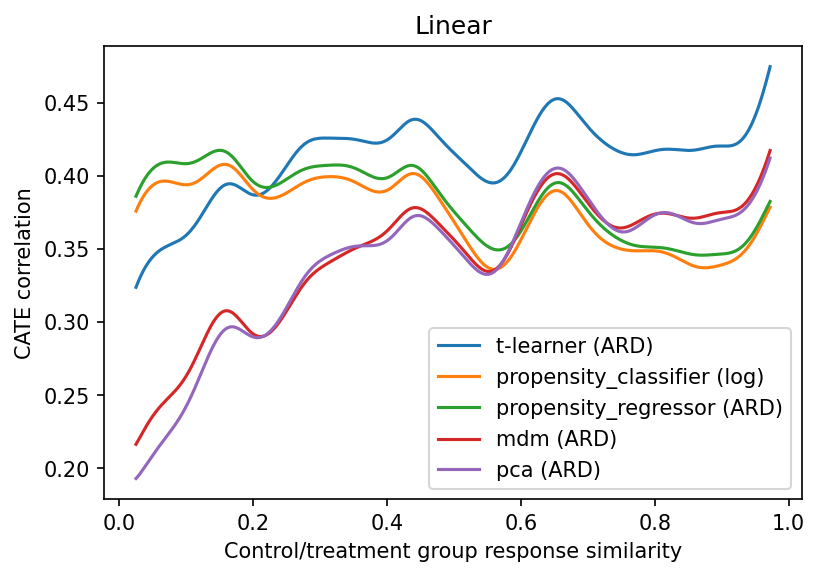

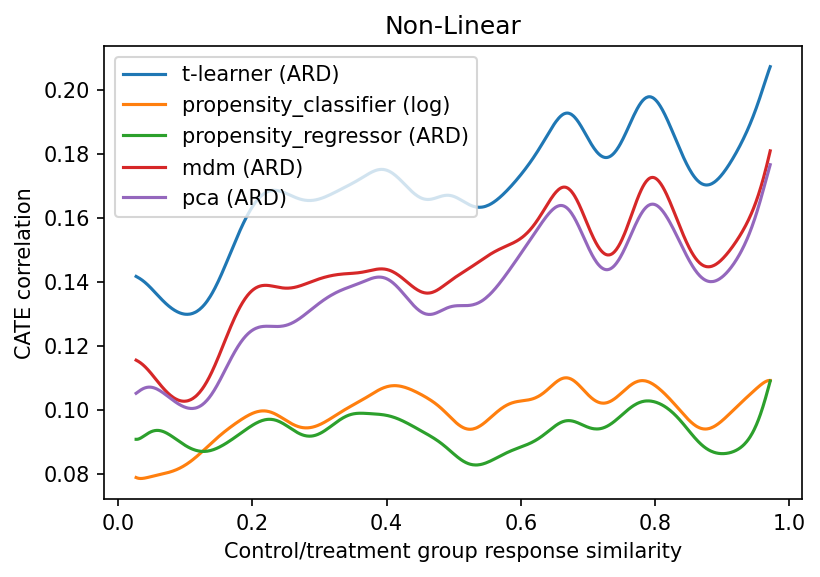

In [11]:
plot_correlations("control_unique", sim_datasets, results, n_data_smooth=30)

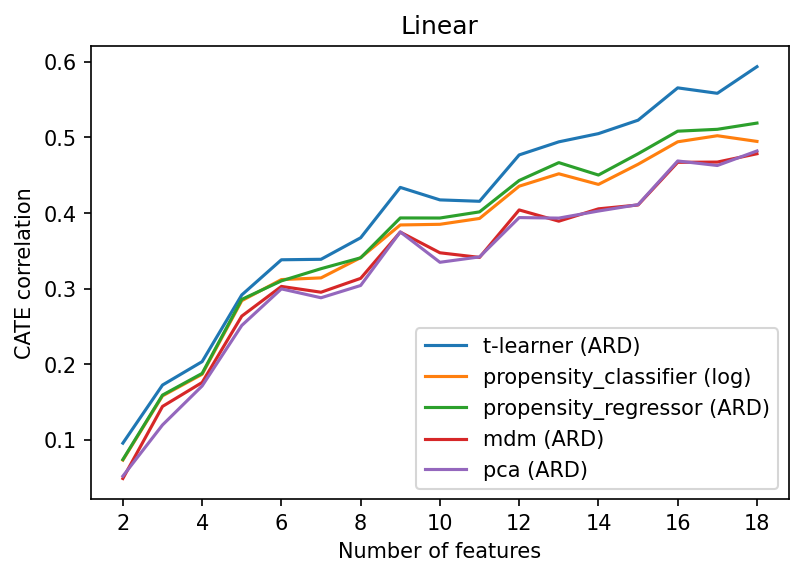

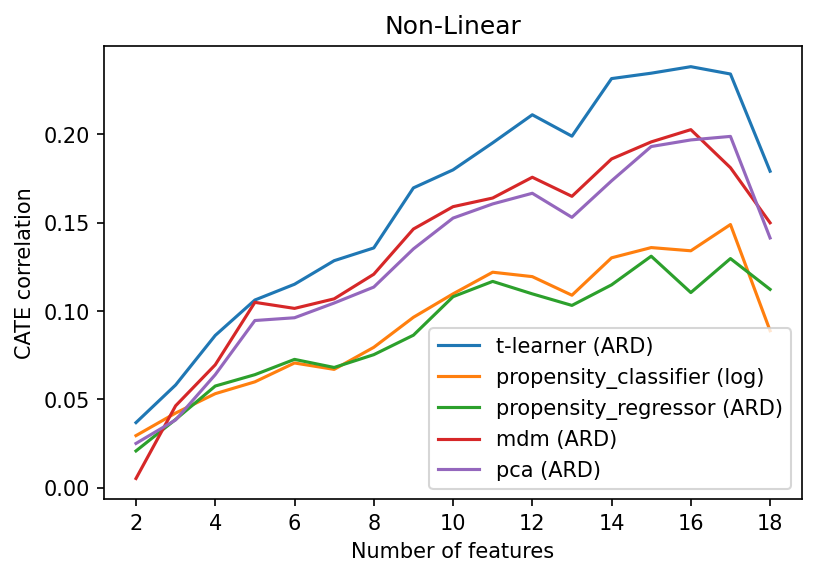

In [12]:
plot_correlations("n_features", sim_datasets, results, n_data_smooth=30)

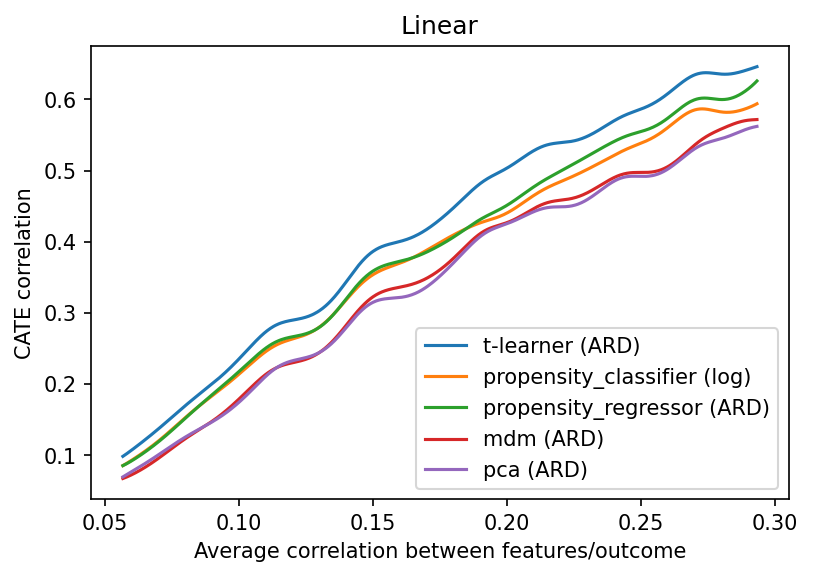

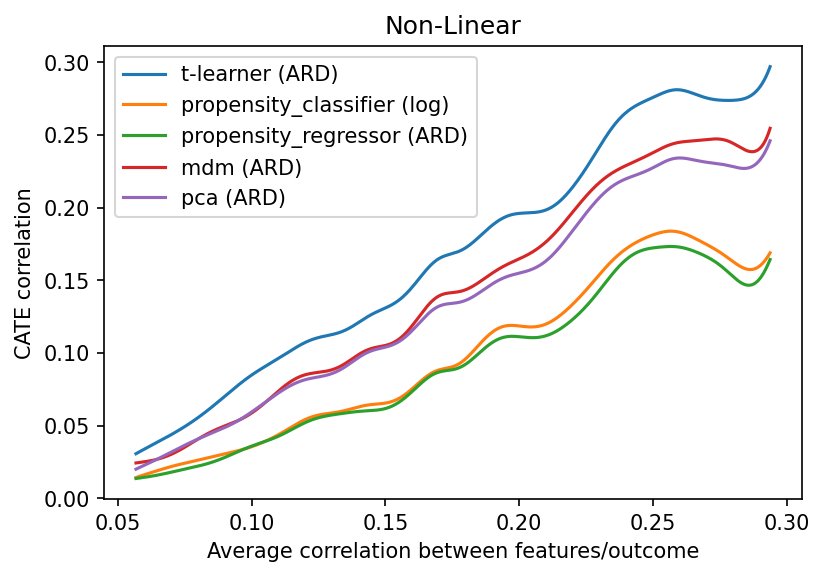

In [13]:
plot_correlations("avg_correlation", sim_datasets, results, n_data_smooth=30)

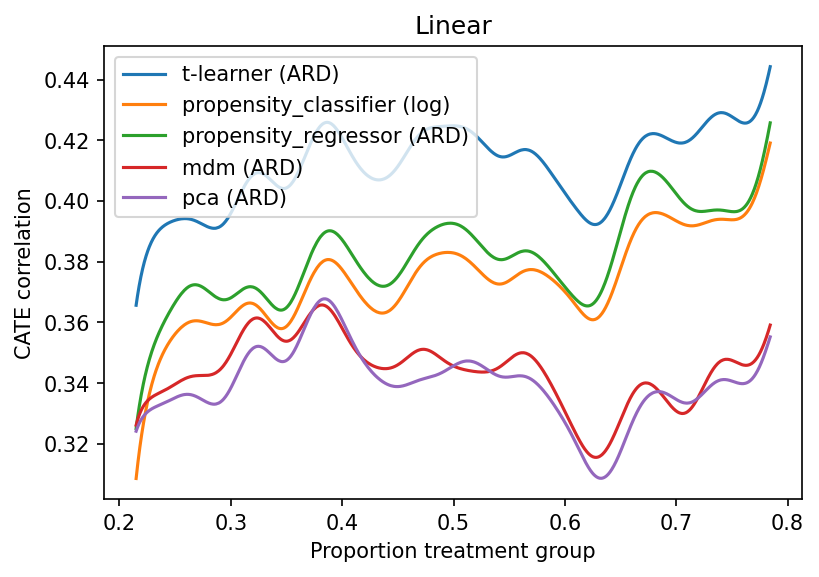

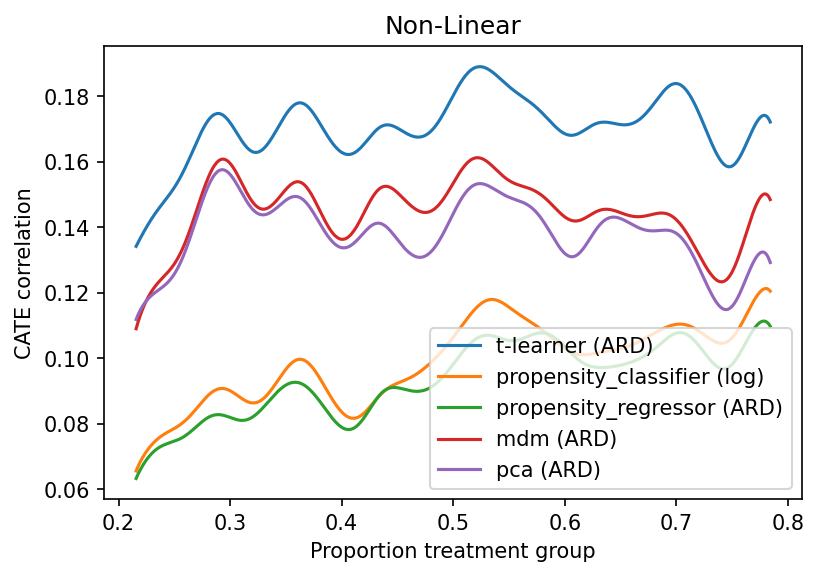

In [14]:
plot_correlations("balance", sim_datasets, results, n_data_smooth=30)

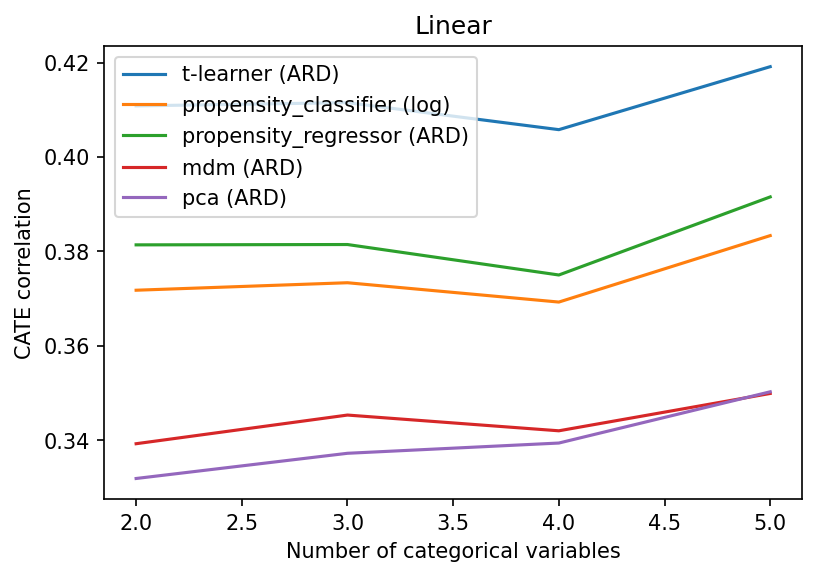

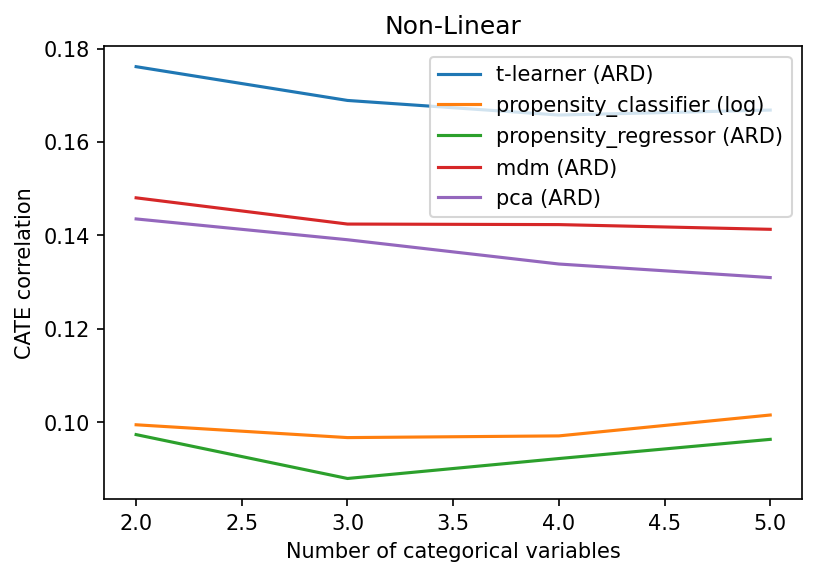

In [15]:
plot_correlations("n_rescale", sim_datasets, results, n_data_smooth=30)

In [16]:
def split_linear(corr, datasets):
    linear_res = [corr[i] for i in range(len(datasets)) if datasets[i].linear == True]
    non_linear_res = [corr[i] for i in range(len(datasets)) if datasets[i].linear == False]
    return linear_res, non_linear_res

In [17]:
print("CATE")
{name: [np.mean(x) for x in split_linear(res, sim_datasets)] for name, res in results.items()}

CATE


{'t-learner (ARD)': [0.41152057902015954, 0.16962946342677954],
 'propensity_classifier (log)': [0.37412183733978815, 0.098634325026731],
 'propensity_regressor (ARD)': [0.38200631842017657, 0.0933963922384311],
 'mdm (ARD)': [0.34392734444762085, 0.14367271624479394],
 'pca (ARD)': [0.3393725475139013, 0.13722131171125093]}